In [1]:
%run ./utility_functions.ipynb

2025-03-04 06:08:03.782613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 06:08:03.895918: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 06:08:04.582062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cdiop/.conda/envs/perso/lib:/lib
2025-03-04 06:08:04.582138: W tensorflow/compile

2.11.0
8
2.11.0


/home/cdiop/.conda/envs/perso/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
strategy = tf.distribute.MirroredStrategy(devices = ["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"])

2025-03-04 06:08:06.747877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-04 06:08:06.750563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-04 06:08:06.753146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-04 06:08:06.755659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-04 06:08:06.764395: I tensorflow/compiler/xla/stream_executo

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


# Load Dataset

In [3]:
image_shape = (96,96,3)

In [4]:
train_dataset_path = "../Dataset/clean/CelebrityFaces/"
valid_dataset_path = "../Dataset/clean/FootballFaces/"

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

trainLoader = Loader(path=train_dataset_path,
                     image_shape=image_shape,
                     batch_size=BATCH_SIZE,
                     max_pos_pairs=3000,
                     apply_augmentation=True,
                     preprocess_pipeline = None,
                     normalize = True)

training_dataset = trainLoader.dataset

validLoader = Loader(path=valid_dataset_path,
                     image_shape=image_shape,
                     batch_size=BATCH_SIZE,
                     max_pos_pairs=500,
                     preprocess_pipeline = None,
                     normalize=True)

validation_dataset = validLoader.dataset

Number of positive pairs: 3000
Number of negative pairs: 3000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Number of positive pairs: 500
Number of negative pairs: 500


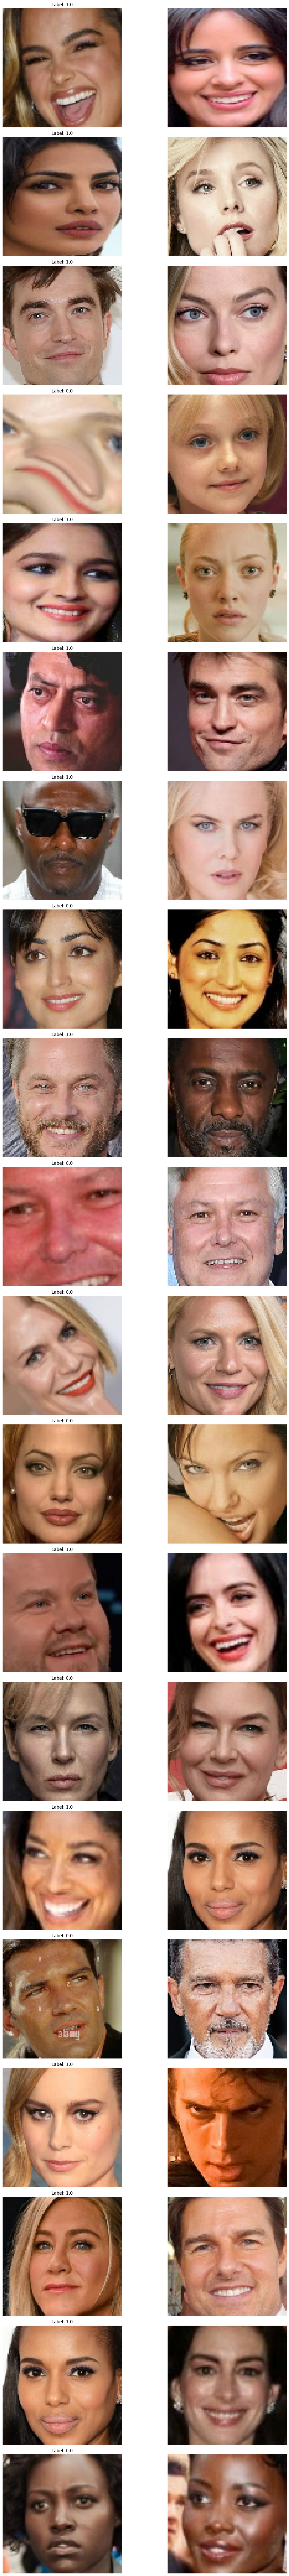

In [5]:
trainLoader.visualize(value_range=(0,1),
                      color_mode_switch=False)

In [6]:
embedding_dataset, class_names = validLoader.create_embedding_dataset()

# Training

## Simple Feature Extractor

In [7]:
log_dir = f"../runs/{datetime.now().strftime('%Y%m%d=%H%M%S')}"
callb = callBacks(log_dir, embedding_dataset, class_names)

with strategy.scope(): 
    
    input_emb = tf.keras.Input(shape=image_shape)

    x = tf.keras.layers.Conv2D(32, (3,3), strides=2)(input_emb)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, (3,3), strides=2)(x)  # Strided conv replaces pooling
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(128, (3,3), strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    # x = tf.keras.layers.Conv2D(256, (3,3), strides=2)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Activation("relu")(x)


    feature_extractor = Model(inputs=input_emb, outputs=x, name="feature_extractor")
    
    optimizer = Adam(learning_rate=0.0001)
    loss_fc = contrastiveLoss(margin=0.5, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE )
    
    s_network = siameseNetwork(feature_extractor, image_shape, distance_metric="cosine_distance", embedding_size=128)

    s_network.compile(optimizer=optimizer,
                      loss = loss_fc)
    
    s_network.fit(training_dataset, epochs=50, validation_data=validation_dataset, callbacks=[callb])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-03-04 06:11:35.940336: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 6000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 2
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
      

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1


2025-03-04 06:11:58.194830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2025-03-04 06:11:58.616392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2025-03-04 06:11:59.344748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2025-03-04 06:12:00.138083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2025-03-04 06:12:03.511951: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f34d37e8260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-04 06:12:03.511994: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-03-04 06:12:03.512001: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2025-03-04 06:12:03.512006: I tensorflow/compiler/xla/s

24/24 [==============================] - ETA: 0s - threshold: 0.6536 - loss: 0.0334 - training_loss: 0.0814 - training_accuracy: 0.5376 - training_sim_distance: 0.6536 - training_dissim_distance: 0.6792

2025-03-04 06:12:05.977385: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:6"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 2
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
      

24/24 [==============================] - 34s 220ms/step - threshold: 0.6494 - loss: 0.0334 - training_loss: 0.0795 - training_accuracy: 0.5369 - training_sim_distance: 0.6494 - training_dissim_distance: 0.6746 - val_threshold: 0.5479 - val_loss: 0.0661 - val_accuracy: 0.5000 - val_sim_distance: 0.0012 - val_dissim_distance: 0.0015
Epoch 2/50
24/24 [==============================] - 10s 77ms/step - threshold: 0.2965 - loss: 0.0239 - training_loss: 0.0252 - training_accuracy: 0.5329 - training_sim_distance: 0.2965 - training_dissim_distance: 0.3068 - val_threshold: 0.2700 - val_loss: 0.0583 - val_accuracy: 0.5000 - val_sim_distance: 8.7520e-04 - val_dissim_distance: 0.0011
Epoch 3/50
24/24 [==============================] - 10s 79ms/step - threshold: 0.2250 - loss: 0.0233 - training_loss: 0.0228 - training_accuracy: 0.5446 - training_sim_distance: 0.2250 - training_dissim_distance: 0.2350 - val_threshold: 0.2222 - val_loss: 0.0603 - val_accuracy: 0.5000 - val_sim_distance: 0.0014 - val_d

## MobileNet

In [ ]:
base_model = MobileNetV3Large(include_top = False,
                              weights = None,
                              input_shape=image_shape,
                              alpha = 1.0,
                              pooling = None,
                              dropout_rate = 0.1)

# num_layers = len(base_model.layers)
# freeze_count = int(0.30 * num_layers)

# for i, layer in enumerate(base_model.layers):
#     if i < freeze_count:
#         layer.trainable = False  # freeze
#     else:
#         layer.trainable = True   # unfreeze

In [ ]:
# embedding_model = s_network.embedding_model
log_dir = f"../runs/{datetime.now().strftime('%Y%m%d=%H%M%S')}"
callb = callBacks(log_dir, embedding_dataset, class_names)

with strategy.scope(): 
    optimizer = Adam(learning_rate=0.00001)
    loss_fc = contrastiveLoss(margin=0.5, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE )
    
    feature_extractor = MobileNetV3Large(include_top = False,
                                        weights = None,
                                        input_shape=image_shape,
                                        alpha = 1.0,
                                        pooling = None,
                                        dropout_rate = 0.1)
    
    s_network = siameseNetwork(feature_extractor, image_shape, distance_metric="cosine_distance", embedding_size=512)

    s_network.compile(optimizer=optimizer,
                      loss = loss_fc)
    
    s_network.fit(training_dataset, epochs=15, validation_data=validation_dataset, callbacks=[callb])

## Nasnet

In [ ]:
base_model = NASNetMobile(input_shape=image_shape,
                         include_top=False,
                         weights=None,
                         input_tensor=None,
                         pooling=None)

In [ ]:
l2_reg = regularizers.l2(0.01)
base_embedding = createEmbedding(base_model, image_shape)
siamese_network = createSiameseNetwork(base_embedding, image_shape)

siamese_network.summary()

In [ ]:
optimizer = Adam(learning_rate=0.0001)
loss_fc = contrastive_loss
acc_metric = BinaryAccuracy(threshold=0.5)

fit(model = siamese_network,
    embedding_model = base_embedding,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    embedding_dataset = embedding_dataset,
    class_names = class_names,
    epochs = 30,
    loss_fc = loss_fc ,
    optimizer = optimizer,
    acc_metric = acc_metric)

## Resnet

In [ ]:
# embedding_model = s_network.embedding_model
log_dir = f"../runs/{datetime.now().strftime('%Y%m%d=%H%M%S')}"
callb = callBacks(log_dir, embedding_dataset, class_names)

with strategy.scope(): 
    optimizer = Adam(learning_rate=0.0001)
    loss_fc = contrastiveLoss(margin=0.5, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE )
    # loss_fc = circleLoss(margin = 0.25, gamma = 64, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    
    feature_extractor = ResNet50V2(input_shape=image_shape,
                                   include_top=False,
                                   weights="imagenet",
                                   input_tensor=None,
                                   pooling=None)
    
    # for layer in feature_extractor.layers[:60]:
    #     layer.trainable = False
    
    s_network = siameseNetwork(feature_extractor, image_shape, distance_metric="cosine_distance", embedding_size=512)

    s_network.compile(optimizer=optimizer,
                      loss = loss_fc)
    
    s_network.fit(training_dataset, epochs=15, validation_data=validation_dataset, callbacks=[callb])

## VGG

In [ ]:
base_model = VGG16(input_shape=image_shape,
                         include_top=False,
                         weights=None,
                         input_tensor=None,
                         pooling=None)

In [ ]:
base_embedding = createEmbedding(base_model, image_shape)
base_embedding.summary()
siamese_network = createSiameseNetwork(base_embedding, image_shape)
siamese_network.summary()

In [ ]:
optimizer = Adam(learning_rate=0.0001)
loss_fc = contrastive_loss
acc_metric = BinaryAccuracy(threshold=0.5)

fit(model = siamese_network,
    embedding_model = base_embedding,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    embedding_dataset = embedding_dataset,
    class_names = class_names,
    epochs = 100,
    loss_fc = loss_fc ,
    optimizer = optimizer,
    acc_metric = acc_metric)

##  Evaluating

In [ ]:
old_weights = siamese_network.get_weights()
path = "../runs/20250204-102132/siamese_model_epoch_20.h5"
siamese_network.load_weights(path)
new_weights = siamese_network.get_weights()

print("Mean of old weights[0]:", old_weights[0].mean())
print("Mean of new weights[0]:", new_weights[0].mean())

In [ ]:
training_dataset
validation_dataset

In [ ]:
acc = evaluate(siamese_network, validation_dataset, 0.39) #0.24 on training set
acc